# Note: This notebook is a work in progress & will be updated continuously until it's ready - 28 May 2021

# Time series forecasting in TensorFlow

The goal of this notebook is to get you familiar with working with time series data.

It won't cover all of the time series field but by the end you will get a fairly good overview of things to consider for time series problems...

### What we're going to cover
* Get data (a time series)
* Format data
  * Turn data into a windowed dataset
  * Training/test sets for time series
  * Univariate - Bitcoin's price history
  * Multivariate - Bitcoin's price history + block size
* Model data
  * Baseline - naive forecasting (use the last timestep to predict the next timestep)
  * Deep model - fully connected
  * Sequence models
    * LSTM
    * Conv1D
  * N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf
* Evaluating a time series model
  * MAE
  * MSE
  * RMSE etc...
* Uncertainty estimates
  * Coconut uncertainty - epistemic uncertainty
  * Subway uncertainty - aleatory uncertainty
* Why forecasting is BS (turkey problem) - https://youtu.be/hRwimmE2wEk
  * Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20 
  * Closed system: try it out 
* Exercises
* Extra-curriculum
  * Time series book - https://otexts.com/fpp2/accuracy.html 


## TODO: What is a time series problem?

* Forecasting
* Classification

## TODO: Get data

Let's predict the price of Bitcoin! Data source: https://www.coindesk.com/price/bitcoin

> **Note:** This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

See this tweet for reference: https://twitter.com/marksaroufim/status/1366871736604532739?s=20

TODO (upload to Google Storage/GitHub): Data: https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv?dl=0

In [1]:
!wget https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-05-29 19:01:30--  https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv [following]
--2021-05-29 19:01:30--  https://www.dropbox.com/s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04366d5cf4cf04abe66a140c3e.dl.dropboxusercontent.com/cd/0/inline/BPZq6D-4gFHNia3T_gh9p9nLcROyeRvzlmu3eXvlcuu985HlnsGDakp3U6_LmdnyT1lvfDnpBpaBOZt2Xah_s6kZPxl59jrPiPRXdFA9q8DHPz_2l2xerz5gb0-DVpdZygSQxEmHdcGrbGcMJL9t3nfp/file# [following]
--2021-05-29 19:01:30--  https://uc04366d5cf4cf04abe66a140c3e.dl.dropboxusercontent.com/cd/0/inline/

In [3]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("RawData_82_1.csv", 
                 #parse_dates=["Date"], 
                 index_col=["index"]) # parse the date column (tell pandas column 1 is a datetime)
df

,Test_Time,Step_Time,Cycle_Index,Step_Index,Voltage,Test_Time.1,Step_Time.1,Cycle_Index.1,Step_Index.1,Current,Test_Time.2,Step_Time.2,Cycle_Index.2,Step_Index.2,Charge_Capacity,Test_Time.3,Step_Time.3,Cycle_Index.3,Step_Index.3,Discharge_Capacity,Test_Time.4,Step_Time.4,Cycle_Index.4,Step_Index.4,Charge_Energy,Test_Time.5,Step_Time.5,Cycle_Index.5,Step_Index.5,Discharge_Energy,Test_Time.6,Step_Time.6,Cycle_Index.6,Step_Index.6,dV/dt
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,120.004700,120.0046,1,1,3.580370,120.004700,120.0046,1,1,0.000000,120.004700,120.0046,1,1,0.000000,120.004700,120.0046,1,1,0.000000,120.004700,120.0046,1,1,0.000000,120.004700,120.0046,1,1,0.000000,120.0047,120.0046,1.0,1.0,-5.531311e-05
1,240.005700,240.0056,1,1,3.581512,240.005700,240.0056,1,1,0.000000,240.005700,240.0056,1,1,0.000000,240.005700,240.0056,1,1,0.000000,240.005700,240.0056,1,1,0.000000,240.005700,240.0056,1,1,0.000000,240.0057,240.0056,1.0,1.0,-7.247925e-05
2,360.002200,360.0021,1,1,3.582036,360.002200,360.0021,1,1,0.000000,360.002200,360.0021,1,1,0.000000,360.002200,360.0021,1,1,0.000000,360.002200,360.0021,1,1,0.000000,360.002200,360.0021,1,1,0.000000,360.0022,360.0021,1.0,1.0,3.337860e-05
3,480.002200,480.0021,1,1,3.582098,480.002200,480.0021,1,1,0.000000,480.002200,480.0021,1,1,0.000000,480.002200,480.0021,1,1,0.000000,480.002200,480.0021,1,1,0.000000,480.002200,480.0021,1,1,0.000000,480.0022,480.0021,1.0,1.0,-1.239777e-05
4,600.000200,600.0001,1,1,3.581778,600.000200,600.0001,1,1,0.000000,600.000200,600.0001,1,1,0.000000,600.000200,600.0001,1,1,0.000000,600.000200,600.0001,1,1,0.000000,600.000200,600.0001,1,1,0.000000,600.0002,600.0001,1.0,1.0,-9.536743e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,211291.701484,685.6057,50,5,2.999986,211291.701484,685.6057,50,5,-6.519866,211291.701484,685.6057,50,5,1.240922,211291.701484,685.6057,50,5,1.241670,211291.701484,685.6057,50,5,5.422492,211291.701484,685.6057,50,5,4.019162,NaN,NaN,NaN,NaN,NaN
1897,211411.849004,120.0009,50,6,3.825990,211411.849004,120.0009,50,6,0.000000,211411.849004,120.0009,50,6,1.240922,211411.849004,120.0009,50,6,1.241803,211411.849004,120.0009,50,6,5.422492,211411.849004,120.0009,50,6,4.019579,NaN,NaN,NaN,NaN,NaN
1898,211531.848504,240.0004,50,6,3.846364,211531.848504,240.0004,50,6,0.000000,211531.848504,240.0004,50,6,1.240922,211531.848504,240.0004,50,6,1.241803,211531.848504,240.0004,50,6,5.422492,211531.848504,240.0004,50,6,4.019579,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1901 entries, 0 to 1900
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Test_Time           1901 non-null   float64
 1   Step_Time           1901 non-null   float64
 2   Cycle_Index         1901 non-null   int64  
 3   Step_Index          1901 non-null   int64  
 4   Voltage             1901 non-null   float64
 5   Test_Time.1         1901 non-null   float64
 6   Step_Time.1         1901 non-null   float64
 7   Cycle_Index.1       1901 non-null   int64  
 8   Step_Index.1        1901 non-null   int64  
 9   Current             1901 non-null   float64
 10  Test_Time.2         1901 non-null   float64
 11  Step_Time.2         1901 non-null   float64
 12  Cycle_Index.2       1901 non-null   int64  
 13  Step_Index.2        1901 non-null   int64  
 14  Charge_Capacity     1901 non-null   float64
 15  Test_Time.3         1901 non-null   float64
 16  Step_T

In [5]:
# TODO: time series often may not have very many samples (e.g. monthly = only 12 per year, daily = 365 per year... etc)
# Deep learning algorithms usually flourish with lots of data (1000's of samples)
len(df)

1901

In [114]:
# Only want closing price
data_rawdata = pd.DataFrame(df["Charge_Capacity"])
data_rawdata.head()

,Charge_Capacity
index,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [115]:
data_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1901 entries, 0 to 1900
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Charge_Capacity  1901 non-null   float64
dtypes: float64(1)
memory usage: 29.7 KB


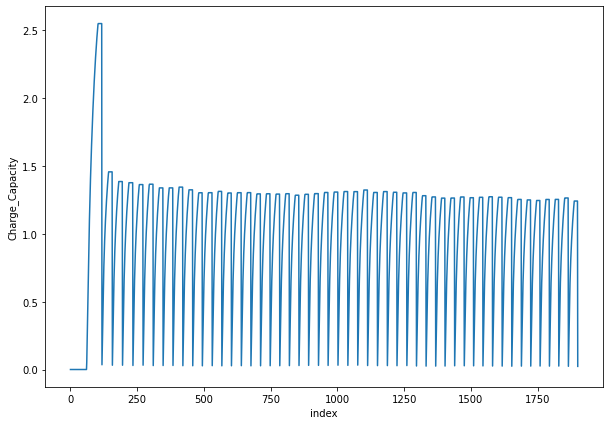

In [116]:
#data_rawdata.plot(figsize=(10, 7));
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot( np.array(data_rawdata))
plt.xlabel("index")
plt.ylabel("Charge_Capacity");
plt.savefig("fig1.pdf",bbox_inches="tight")

In [117]:
data_rawdata.head()

,Charge_Capacity
index,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


### Importing time series as a CSV

In [118]:
# # Importing with Python CSV - https://realpython.com/python-csv/
# import csv
# from datetime import datetime

# timesteps = []
# btc_price = []
# with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
#   csv_reader = csv.reader(f, delimiter=",")
#   next(csv_reader) # skip first line
#   for line in csv_reader:
#     timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
#     btc_price.append(float(line[2])) # get the closing price as float

# # View first 10
# timesteps[:10], btc_price[:10]

In [119]:
# # Plot from CSV
# import matplotlib.pyplot as plt
# import numpy as np
# plt.figure(figsize=(10, 7))
# plt.plot(timesteps, np.array(btc_price))
# plt.xlabel("Date")
# plt.ylabel("BTC Price");

## TODO: Format data 

* Turn data into a windowed dataset
* Training/test sets for time series
* Univariate - Bitcoin's price history
* Multivariate - Bitcoin's price history + block size

### TODO: Create train & test sets for time series

* Note: cannot do random split, time series will buckle under this (using future values in the past)
* Need to make train set: values from past, test set: values from "future"

In [120]:
# Get bitcoin date array
timesteps = data_rawdata.index.to_numpy()
prices = data_rawdata["Charge_Capacity"].to_numpy()

timesteps[:10], prices[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [121]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((1520,), (381,), (1520,), (381,))

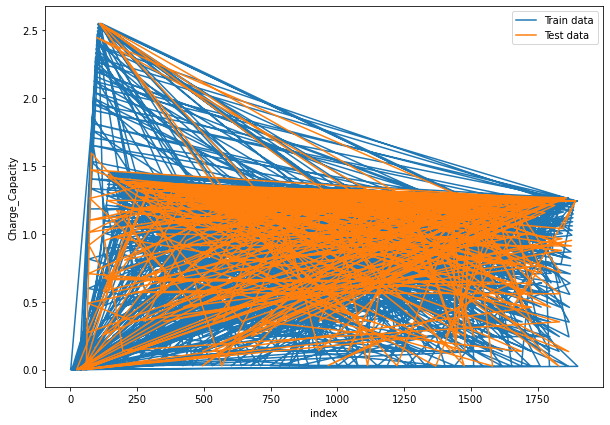

In [122]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train,label="Train data")
plt.plot(X_test, y_test,label="Test data")
plt.xlabel("index")
plt.ylabel("Charge_Capacity")
plt.legend()
plt.show();

* TODO: Note: time series forecasting can often have many less data points than traditional deep learning projects (e.g. the entire history of BTC daily price data = only ~3000 samples)

* TODO: What kind of steps should we predict? E.g. 80/20 split is that realisitic? You may want to use all of the data up until the last week...

In [123]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1520,), (381,), (1520,), (381,))

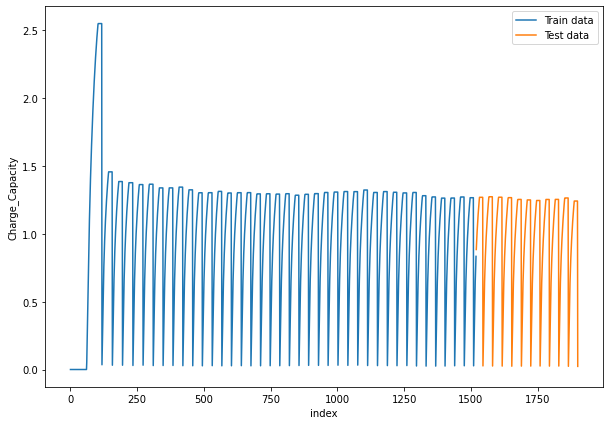

In [124]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train, label="Train data")
plt.plot(X_test, y_test, label="Test data")
plt.xlabel("index")
plt.ylabel("Charge_Capacity")
plt.legend()
plt.savefig("fig2.pdf",bbox_inches="tight")
plt.show();

### TODO: Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [125]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("index")
  plt.ylabel("Charge_Capacity")
  # plt.xlim(0,1925)
  # plt.ylim(2.8,4.5)
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

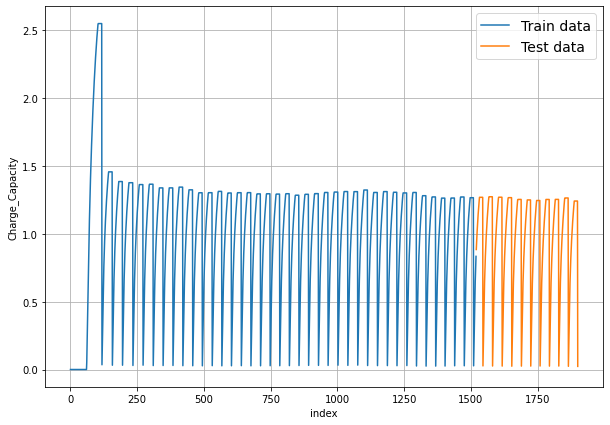

In [126]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, format="-", label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format="-", label="Test data")
plt.savefig("fig3.pdf",bbox_inches="tight")

## TODO: Modelling Experiments

* Baseline - naive forecasting
* Deep model - fully connected
  * Fully connected with different size window/horizon
  * -> How does a larger window effect a smaller horizon?
  * -> Model 1: horizon=1, window=7
  * -> Model 2: horizon=1, window=30
  * -> Model 3: horizon=7, window=30
* Sequence models
  * LSTM
  * Conv1D
* N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf

## Model 0: Naive forecast (baseline)

Naive forecast = Use the previous timestep to predict the next timestep

$$\hat{y}_{t} = y_{t-1}$$ 

In [127]:
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([0.88377225, 0.92991292, 0.97244704, 1.01182187, 1.04832613,
       1.08224308, 1.1139127 , 1.1436311 , 1.17161977, 1.19801402])

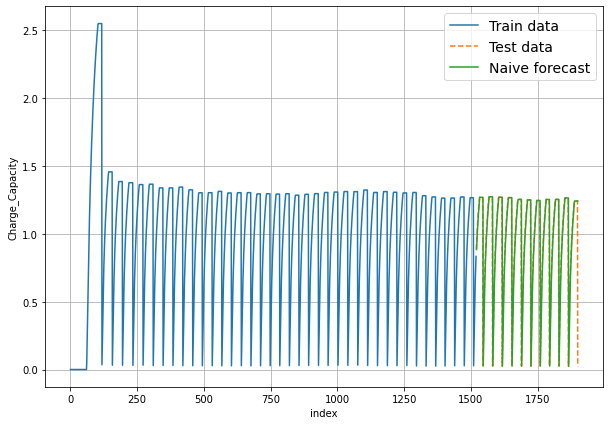

In [128]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, format="-", label="Train data")
plot_time_series(timesteps=X_test, values=y_test, format="--", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label="Naive forecast")
plt.savefig("fig4.pdf",bbox_inches="tight");

The naive forecast looks like it's following the data well. But let's zoom in to take a better look.

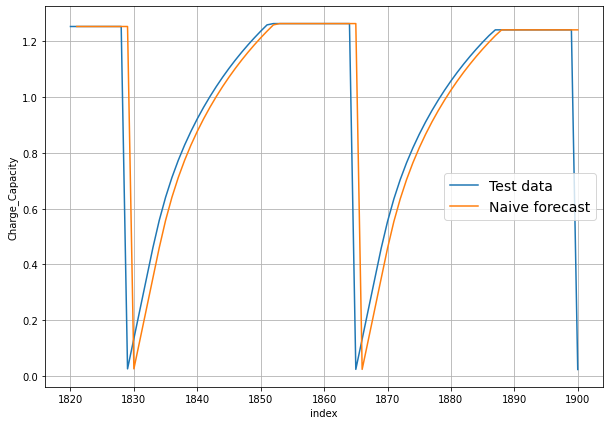

In [129]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=X_test, values=y_test, format="-", start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, label="Naive forecast")
plt.savefig("fig5.pdf",bbox_inches="tight");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

TK - add image for naive forecast (previous step to predict next step) 

## TODO: Evaluating a time series model

TK - this can be a function for each model (compares predictions to ground truth...)

TK - metrics for evaluating time series models: https://otexts.com/fpp2/accuracy.html

Scale-dependent erros (these can't be used to make comparisons between series that involve different units):
* MAE - a forecast method that minimises the MAE will lead to forecasts of the median
* RMSE - a forecast method that minimisies RMSE will lead to forecasts of the mean

Percentage errors: 
* MAPE (mean absolute percentage error) 
* sMAPE (recommended not to be used, though it is used in forecasting competitions)

Scaled errors (these are good when comparing forecasts accuracy across series with different units) - https://otexts.com/fpp2/accuracy.html#scaled-errors:
* MASE (mean absolute scaled error) 
  * There are two kinds of MASE, one for seasonal, one for non-seasonal data
    * "To take a non-seasonal example, consider the Google stock price..."


In [130]:
import tensorflow as tf

In [131]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [132]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [133]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 0.069095865,
 'mape': 150.98776,
 'mase': 0.99912435,
 'mse': 0.04638899,
 'rmse': 0.21538104}

## TODO: Mention other kinds of models which can be used for baselines

* TensorFlow Decision Forest
* Moving average
* Etc...
* Focused on pure TensorFlow kinds of models

## Windowing dataset

Why do we window?

TODO: We can turn our time series data into a **supervised learning problem**: use windows of the past to predict the future.

Want:

```
# Window for a week (univariate time series)
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [134]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [135]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [136]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=10, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # print(len(x)-1)
  # start = len(x) % window_size # account for data which doesn't fit into window, cut off at start
  # print(start)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0) # create 2D array of window_size
  # print(f"Window step:\n {window_step[-5:]}")
  # window_indexes = start + window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon+start-1)), axis=0).T # create 2D array of windows of size window_size
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:2], window_indexes[-2:]}")
  windowed_array = x[window_indexes] # get the original array indexed with windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [137]:
len(prices) % WINDOW_SIZE

4

In [138]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1894, 1894)

### TODO: Make train/test splits after windowing, this helps with evaluation...

In [139]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [140]:
(2224, 2224, 556, 556)

(2224, 2224, 556, 556)

In [141]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1515, 379, 1515, 379)

In [142]:
train_windows[:5], train_labels[:5]

(array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

## TODO: Make a modelling checkpoint... 

We need to save our model's best performance. 

In [143]:
import os

In [144]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## TODO: Model 1: Dense model (window = 7, horizon = 1)

* -> How does a larger window effect a smaller horizon?
* -> Model 1: horizon=1, window=7
* -> Model 2: horizon=1, window=30
* -> Model 3: horizon=7, window=30

In [145]:
import tensorflow as tf
from tensorflow.keras import layers

In [146]:
len(train_windows), len(test_windows), len(full_windows)

(1515, 379, 1894)

In [147]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)                              
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_1.fit(x=train_windows, 
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3828 - val_loss: 0.1920
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1903 - val_loss: 0.1521
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1333 - val_loss: 0.0996
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0947 - val_loss: 0.0777
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0656
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0701 - val_loss: 0.0612
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0580
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 8/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0598 - val_loss: 0.0530
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0534
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0552 - val_loss: 0.0535
Epoch 11/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0499
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 12/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0553
Epoch 13/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0544 - val_loss: 0.0562
Epoch 14/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0497
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 15/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0491
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 16/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0483
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 17/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0524
Epoch 18/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0540
Epoch 19/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0563
Epoch 20/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0490
Epoch 21/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0465
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 22/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0453
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 23/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0461
Epoch 24/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0449
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 25/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0446
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 26/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0452 - val_loss: 0.0441
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 27/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0454
Epoch 28/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0464
Epoch 29/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0464
Epoch 30/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0471 - val_loss: 0.0512
Epoch 31/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0522
Epoch 32/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0450
Epoch 33/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.0440
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 34/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0504
Epoch 35/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0488
Epoch 36/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0454 - val_loss: 0.0491
Epoch 37/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0452
Epoch 38/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0410
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 39/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0405 - val_loss: 0.0432
Epoch 40/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0407 - val_loss: 0.0398
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 41/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0406 - val_loss: 0.0401
Epoch 42/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0419 - val_loss: 0.0476
Epoch 43/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0409
Epoch 44/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0398 - val_loss: 0.0394
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 45/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0482 - val_loss: 0.0642
Epoch 46/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0546
Epoch 47/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0388
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


Epoch 48/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0458 - val_loss: 0.0459
Epoch 49/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0437 - val_loss: 0.0438
Epoch 50/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0451 - val_loss: 0.0521
Epoch 51/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0405
Epoch 52/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0396
Epoch 53/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0425 - val_loss: 0.0409
Epoch 54/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0423
Epoch 55/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0413
Epoch 56/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0491
Epoch 57/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0451


In [148]:
# Evaluate
model_1.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 0.0401


0.040099069476127625

In [149]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 2ms/step - loss: 0.0388


0.03878484666347504

### TODO: Making forecasts with a model

* We could make forecasts on the test windows, however this would end up in less prediction values than in the `y_test`
* Instead, we're going to make predictions on the full dataset windows 

In [150]:
def make_forecast(model, input_data):
  """
  Uses model to make forecasts on input_data.

  Input_data must be windowed version of whole dataset, otherwise forecasts won't match size of y_test.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model forecast on input_data from split_size-window_size onwards.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions 

In [151]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
len(model_1_preds)

379

In [152]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.9728841, 1.0121295, 1.0490025, 1.0834665, 1.115633 , 1.1449385,
       1.1723591, 1.1983032, 1.2229159, 1.2463032], dtype=float32)>

In [153]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 0.038784854,
 'mape': 144.3073,
 'mase': 0.5602573,
 'mse': 0.044115588,
 'rmse': 0.21003711}

In [154]:
# # Model 1 with 10 epochs & no block_reward variable
# {'mae': 763.506,
#  'mape': 3.3924627,
#  'mase': 1.3412685,
#  'mse': 1933137.0,
#  'rmse': 1390.3729}

# # Model 1 with 100 epochs & no block_reward variable
# {'mae': 568.5498,
#  'mape': 2.549229,
#  'mase': 0.99878454,
#  'mse': 1172587.6,
#  'rmse': 1082.8608}

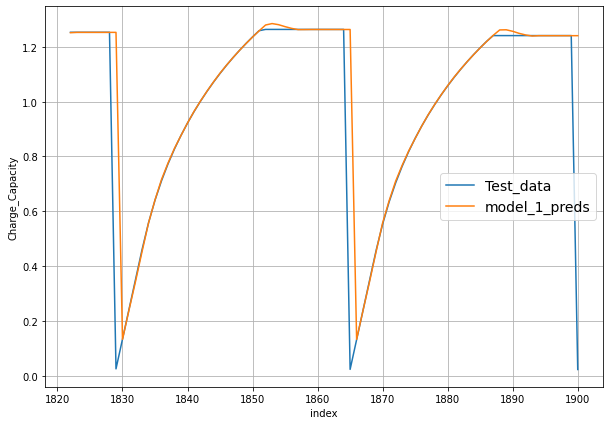

In [155]:
offset = 300
plt.figure(figsize=(10, 7))
# plt.ylim(2.9,4.5)
# plt.xlim(0,1920)
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, label="model_1_preds")
plt.savefig("fig6.pdf",bbox_inches="tight")

## TODO: Model 2: Dense (window = 30, horizon = 1)

Same model as model 1 except with different data.

TK - What happens if we make a larger window & horizon?

* TK - Window & horizon values are values you can tune...

In [156]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [157]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1871, 1871)

In [158]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1496, 375, 1496, 375)

In [159]:
# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/10
47/47 [==============================] - 0s 4ms/step - loss: 0.3383 - val_loss: 0.1574
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 2/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1258 - val_loss: 0.1064
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 3/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1005 - val_loss: 0.1037
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 4/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0675
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 5/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0611
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 6/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0734
Epoch 7/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0586
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 8/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0523
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


Epoch 9/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0713
Epoch 10/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0555


In [160]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 0.0555


0.055518172681331635

In [161]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 1ms/step - loss: 0.0523


0.052274465560913086

In [162]:
# Get forecast predictions
model_2_preds = make_forecast(model_2,
                              input_data=test_windows)

In [163]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 0.052274466,
 'mape': 152.07101,
 'mase': 0.75118876,
 'mse': 0.046704262,
 'rmse': 0.21611169}

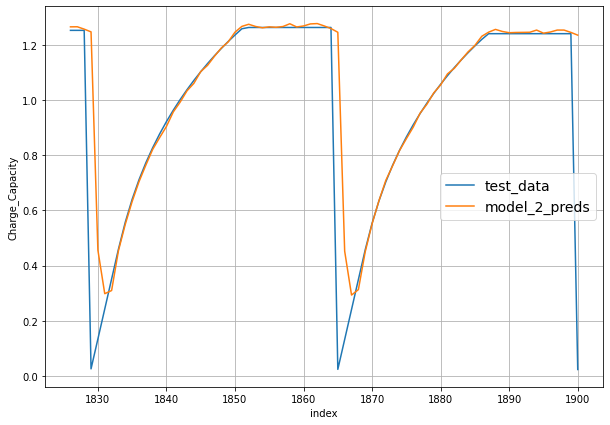

In [164]:
offset = 300
plt.figure(figsize=(10, 7))

# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, label="model_2_preds") 
plt.savefig("fig7.pdf",bbox_inches="tight")

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.



In [165]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1865, 1865)

In [166]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1492, 373, 1492, 373)

In [167]:
# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/10
47/47 [==============================] - 0s 4ms/step - loss: 0.3618 - val_loss: 0.1897
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 2/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2007 - val_loss: 0.1421
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 3/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1659 - val_loss: 0.1195
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 4/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1460 - val_loss: 0.1028
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 5/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1338 - val_loss: 0.0974
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 6/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1264 - val_loss: 0.0914
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 7/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1209 - val_loss: 0.0917
Epoch 8/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1168 - val_loss: 0.0886
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


Epoch 9/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1150 - val_loss: 0.0896
Epoch 10/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1126 - val_loss: 0.0824
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


In [168]:
model_3.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 2ms/step - loss: 0.0824


0.08241664618253708

TODO: The error will be higher because we're predicting 7 steps at a time... the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days out...).

In [169]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_forecast(model_3,
                              input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[0.954828  , 0.97649854, 1.0022576 , 1.0606707 , 1.0916079 ,
        1.1165949 , 1.1423851 ],
       [0.9987372 , 1.0201302 , 1.0406536 , 1.0824414 , 1.1395215 ,
        1.1348716 , 1.196671  ],
       [1.0469562 , 1.0664674 , 1.0733055 , 1.1232361 , 1.1842742 ,
        1.1743714 , 1.2295343 ],
       [1.0820361 , 1.0866622 , 1.109267  , 1.148765  , 1.1659778 ,
        1.2049125 , 1.23513   ],
       [1.1181846 , 1.1407603 , 1.1405287 , 1.1007388 , 1.2366041 ,
        1.2122858 , 1.2690216 ]], dtype=float32)>

In [170]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([0.02845126, 0.02236317, 0.01728858, 0.02088284, 0.02629069,
        0.01684732, 0.01140807, 0.01469553, 0.01150566, 0.01080007,
        0.0087642 , 0.00922947, 0.01533421, 0.01411535, 0.00928778,
        0.00967792, 0.01059328, 0.18811464, 0.21024704, 0.25792477,
        0.30491224, 0.36188462, 0.48470688, 0.5953132 , 0.16827856,
        0.05537394, 0.05787539, 0.04377189, 0.03571684, 0.03166265,
        0.02164796, 0.0329161 , 0.03111272, 0.02693752, 0.02288658,
        0.02626987, 0.02056318, 0.01681849, 0.01936769, 0.02632378,
        0.01602573, 0.01134375, 0.0142074 , 0.01019694, 0.010435  ,
        0.0097456 , 0.01110664, 0.01627271, 0.01432131, 0.00980731,
        0.00986106, 0.01107935, 0.0152681 , 0.21239899, 0.21211906,
        0.22839151, 0.269089  , 0.34274212, 0.46365672, 0.58164823,
        0.14942935, 0.03737112, 0.0387584 , 0.02474274, 0.01798513,
        0.01572713, 0.01663081, 0.01660849, 0.01806381, 0.01936816,
        0.0198693 , 0.01298939, 0.0176607

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [171]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [172]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 0.08241664,
 'mape': 128.61707,
 'mase': 1.2254498,
 'mse': 0.051516563,
 'rmse': 0.11686517}

If we try to plot our multi-horizon predicts, we're going to get a funky looking plot.

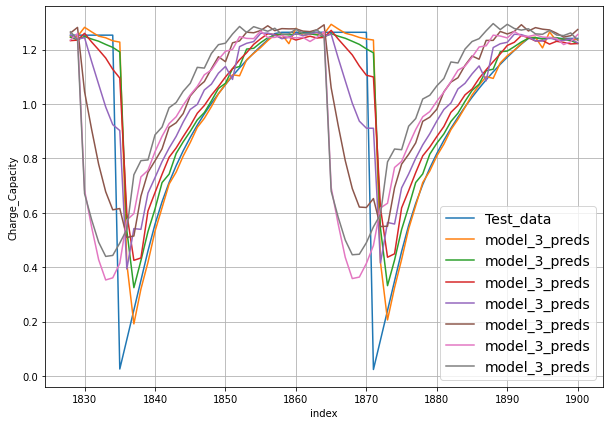

In [173]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds") 
plt.savefig("fig8.pdf",bbox_inches="tight")

TODO: what information do we lose through aggregated the predictions? E.g. going from 7 steps at a time to one step at a time? 

Again, we can fix this by aggregating our model's predictions.

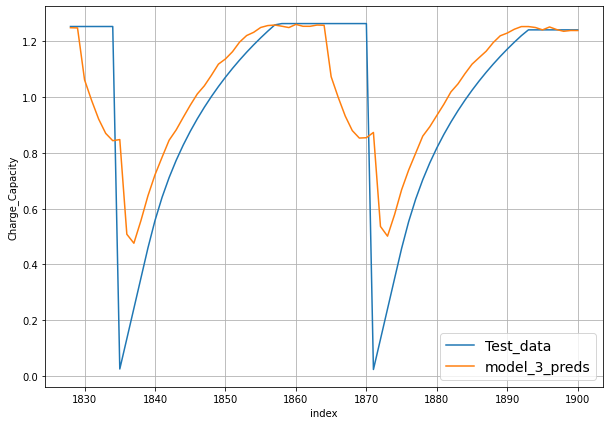

In [174]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, label="model_3_preds")
plt.savefig("fig9.pdf",bbox_inches="tight")

Which of our models is performing best so far?

In [175]:
model_1_results, model_2_results

({'mae': 0.038784854,
  'mape': 144.3073,
  'mase': 0.5602573,
  'mse': 0.044115588,
  'rmse': 0.21003711},
 {'mae': 0.052274466,
  'mape': 152.07101,
  'mase': 0.75118876,
  'mse': 0.046704262,
  'rmse': 0.21611169})

In [176]:
naive_results["mae"]

0.069095865

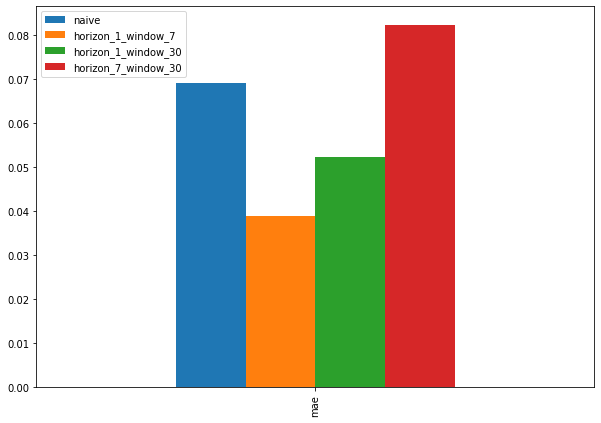

In [177]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");
plt.savefig("fig10.pdf",bbox_inches="tight")

Our naive model is performing best (it's very hard to beat a naive model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

## TODO: Model 4: Conv1D

In [178]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [179]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(1894, 1894)

In [180]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1515, 379, 1515, 379)

TK - Since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = 1` - our model views one week of data at a time to predict the next day

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [181]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a `tf.keras.layers.Lamdba` (called a Lambda layer) to do this for us in our model.

In [182]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [183]:
# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels, 
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/10
48/48 [==============================] - 1s 5ms/step - loss: 0.3025 - val_loss: 0.1325
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 2/10
48/48 [==============================] - 0s 3ms/step - loss: 0.1027 - val_loss: 0.0684
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 3/10
48/48 [==============================] - 0s 3ms/step - loss: 0.0682 - val_loss: 0.0640
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 4/10
48/48 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0562
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 5/10
48/48 [==============================] - 0s 3ms/step - loss: 0.0565 - val_loss: 0.0487
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 6/10
48/48 [==============================] - 0s 3ms/step - loss: 0.0555 - val_loss: 0.0452
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 7/10
48/48 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0443
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 8/10
48/48 [==============================] - 0s 3ms/step - loss: 0.0485 - val_loss: 0.0503
Epoch 9/10
48/48 [==============================] - 0s 3ms/step - loss: 0.0449 - val_loss: 0.0428
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


Epoch 10/10
48/48 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0487


In [184]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 128)            2816      
_________________________________________________________________
dense_143 (Dense)            (None, 1, 1)              129       
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [185]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

12/12 [==============================] - 0s 2ms/step - loss: 0.0428


0.042786575853824615

In [186]:
# Make predictions
model_4_preds = make_forecast(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.97575074, 1.0150297 , 1.0518196 , 1.0861691 , 1.1178395 ,
       1.1468993 , 1.1741416 , 1.1998956 , 1.224295  , 1.2474477 ],
      dtype=float32)>

In [187]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 0.042786572,
 'mape': 146.15668,
 'mase': 0.61806315,
 'mse': 0.044655208,
 'rmse': 0.21131779}

## TODO: Model 5: RNN (LSTM)

TK (image) - make an image of inputs -> model -> output 

In [188]:
len(train_windows), len(train_labels)

(1515, 1515)

In [189]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.Conv1D(128, kernel_size=3, padding="causal", activation="relu")(x)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
# x = layers.Dropout(0.05)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/10
48/48 [==============================] - 1s 9ms/step - loss: 0.5447 - val_loss: 0.2028
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 2/10
48/48 [==============================] - 0s 5ms/step - loss: 0.1858 - val_loss: 0.1464
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 3/10
48/48 [==============================] - 0s 5ms/step - loss: 0.1335 - val_loss: 0.0922
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 4/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0837 - val_loss: 0.0613
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 5/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0737 - val_loss: 0.0580
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 6/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0676 - val_loss: 0.0545
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 7/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0628 - val_loss: 0.0530
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 8/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0598 - val_loss: 0.0554
Epoch 9/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0590 - val_loss: 0.0497
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


Epoch 10/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0567 - val_loss: 0.0480
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


In [190]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               69632     
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 129       
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [191]:
# Make predictions with our LSTM model
model_5_preds = make_forecast(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.9764084, 1.0142791, 1.0492718, 1.0817119, 1.1118457, 1.1399484,
       1.1662973, 1.1909144, 1.2140081, 1.235874 ], dtype=float32)>

In [192]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 0.048000924,
 'mape': 150.01564,
 'mase': 0.69338584,
 'mse': 0.04623916,
 'rmse': 0.21503294}

Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
# Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE -> HORIZON
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas `dropna()` method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

## TODO: Model 8: N-BEATs algorithm

* Build model - Figure 1: https://arxiv.org/pdf/1905.10437.pdf
* Hyperparameters for N-Beats paper are available in Appendix D
* TODO: Does ensembling with different loss functions lead to some kind of pseudo uncertainty...?
* “N-BEATS is implemented and trained in TensorFlow”

In [193]:
# Create NBeatsBlock
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, 
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs 
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # TODO: are these the right dimensions?
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [194]:
# dummy_inputs = tf.expand_dims(tf.range(7) + 1, axis=0)
# dummy_inputs

In [195]:
# nbeats_block_layer(dummy_inputs)

In [196]:
# Demo the subtract layer...
X1 = tf.range(10) + 10
X2 = tf.range(10)
input_1 = layers.Input(shape=(10))
input_2 = layers.Input(shape=(10))
subtract_layer = layers.subtract([input_1, input_2])
subtract_model = tf.keras.Model(inputs=[input_1, input_2], outputs=subtract_layer)
print(X1)
print(X2)
subtract_model([X1, X2]).numpy()

tf.Tensor([10 11 12 13 14 15 16 17 18 19], shape=(10,), dtype=int32)
tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)


array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.], dtype=float32)

In [197]:
# Instantiate input variables
WINDOW_SIZE = 7 # how far to lookback
HORIZON = 1 # how far to predict forward
BATCH_SIZE = 1024 # how many samples to look at per batch

# Values from paper (see Figure 1/Appendix D)
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [198]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
data_rawdata.head()

,Charge_Capacity
index,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [199]:
# Add windowed columns
data_rawdata_nbeats = data_rawdata.copy()
for i in range(WINDOW_SIZE):
  data_rawdata_nbeats[f"Charge_Capacity+{i+1}"] = data_rawdata_nbeats["Charge_Capacity"].shift(i+1)
data_rawdata_nbeats.dropna().head()

,Charge_Capacity,Charge_Capacity+1,Charge_Capacity+2,Charge_Capacity+3,Charge_Capacity+4,Charge_Capacity+5,Charge_Capacity+6,Charge_Capacity+7
index,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
# Make features and labels
X = data_rawdata_nbeats.dropna().drop("Charge_Capacity", axis=1)
y = data_rawdata_nbeats.dropna()["Charge_Capacity"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1515, 1515, 379, 379)

In [201]:
# Create TensorFlow dataset - from_tensor_slices is best when your data fits in memory: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels & features
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [202]:
tf.random.set_seed(42)

# Setup NBEATs Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# Build stacks of blocks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Create initial backcast and forecast input
residuals, forecast = nbeats_block_layer(stack_input)

# Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") # https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
stack_model = tf.keras.Model(inputs=stack_input, outputs=forecast, name="Stack_Model")

# Compile
stack_model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=["mae", "mse"])

# Fit
stack_model.fit(train_dataset,
                epochs=5000,
                validation_data=test_dataset,
                verbose=0,
                # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00251: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00351: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [203]:
stack_model.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 0.0402 - mae: 0.0402 - mse: 0.0440


[0.04021245613694191, 0.04021245613694191, 0.04400279372930527]

In [204]:
stack_preds = make_forecast(stack_model, test_dataset)
stack_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.96549237, 1.0060183 , 1.0429364 , 1.0761865 , 1.1062164 ,
       1.133834  , 1.1595017 , 1.1831336 , 1.204621  , 1.2242824 ],
      dtype=float32)>

In [205]:
stack_results = evaluate_preds(y_true=y_test,
                               y_pred=stack_preds)
stack_results

{'mae': 0.040212456,
 'mape': 144.22115,
 'mase': 0.5808794,
 'mse': 0.044002794,
 'rmse': 0.20976843}

In [206]:
# TODO: This will error out unless a "get_config()" method is implemented
stack_model.save("stack_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: stack_model/assets


INFO:tensorflow:Assets written to: stack_model/assets


# TODO: Create an ensemble

* We'll combine the predictions of 3 versions of `simple_model` and see what happens:
  * MAE
  * MSE
  * MAPE

In [207]:
%%time

tf.random.set_seed(42)

preds = {}
for loss_function in ["mae", "mse", "mape"]:
  print(f"Optimizing model by reducing: {loss_function}")

  # construct simple model
  simple_model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
  ])

  simple_model.compile(loss=loss_function,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["mae", "mse"])

  simple_model.fit(train_dataset,
                   epochs=1000,
                   verbose=0,
                   validation_data=test_dataset,
                   # Stop when a model stops improving for ~200 epochs and lower the learning rate when improvement plateau's
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

  simple_model_preds = tf.squeeze(simple_model.predict(test_dataset))

  # Append predictions with target loss function to dictionary
  preds[loss_function] = simple_model_preds

Optimizing model by reducing: mae

Epoch 00199: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00528: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00628: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00728: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Optimizing model by reducing: mse

Epoch 00679: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00779: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape
CPU times: user 1min 5s, sys: 4.33 s, total: 1min 9s
Wall time: 57.4 s


In [208]:
ensemble_preds = np.array(list(preds.values()))
ensemble_preds.shape

(3, 379)

In [209]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 0.06544519,
 'mape': 129.39041,
 'mase': 0.9453728,
 'mse': 0.038419317,
 'rmse': 0.19600846}

### Plotting the variance (prediction intervals) of our ensemble

* See here for more: https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html#Continuous-Errors
* And here: https://stackoverflow.com/a/12958534/7900723 

In [210]:
# Get the variance of different ensemble preds (these are how much predictions vary accross loss metrics)
ensemble_var = tf.math.reduce_variance(ensemble_preds, axis=0)
ensemble_var[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.5547086e-05, 2.1141432e-05, 2.0679543e-05, 1.9045483e-05,
       1.6861120e-05, 1.5326172e-05, 3.9343868e-05, 5.8569066e-04,
       4.7761323e-03, 1.2140706e-02], dtype=float32)>

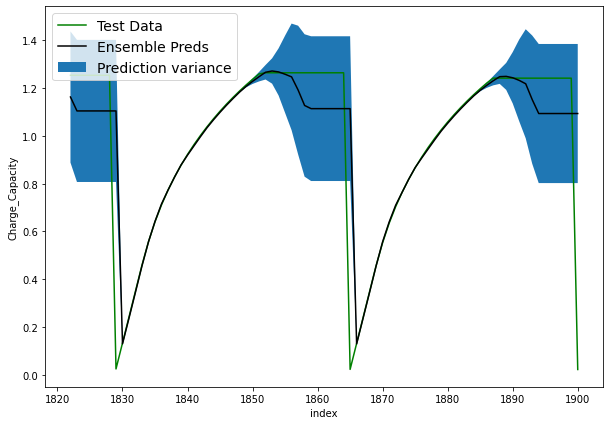

In [213]:
# Plot the variance/median of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

offset=300
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Preds")
plt.xlabel("index")
plt.ylabel("Charge_Capacity")
plt.fill_between(X_test.index[offset:], 
                 (ensemble_median-ensemble_var)[offset:], 
                 (ensemble_median+ensemble_var)[offset:], label="Prediction variance")
plt.legend(loc="upper left", fontsize=14);

## TODO: Plot uncertainty/prediction intervals on the future forecasts

* To do this, make a function to make future forecasts in an ensemble format
* Return the future predictions as well as their variance(s) (from the ensemble)

# TODO: Why forecasting is BS (turkey problem)

TK - inject a turkey problem piece of data into the model & see how it effects (e.g. 1 data point that's 50x of outlier)

* See this video: https://youtu.be/hRwimmE2wEk
* Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20
* Closed system: try it out

# TODO: Exercises

* Does scaling the data help for multivariate data? (e.g. getting all of the values between 0 & 1) 

# TODO: Extra-curriculum

* Evaluation metrics - https://otexts.com/fpp2/accuracy.html 
* 